In [1]:
import numpy as np
import pandas as pd

# preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
healthInsurance = pd.read_csv('insurance_dc.csv')

In [5]:
healthInsurance = healthInsurance.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
healthInsurance.head()

,Age,Tobacco,IndividualRate,IndividualTobaccoRate,IssuerId,BenefitName,IsCovered,IsEHB,QuantLimitOnSvc,IsExclFromInnMOOP,IsExclFromOonMOOP,MetalLevel,DentalOnlyPlan,MarketCoverage,StateCode
0,0,0,53.0,NaN,21989,73,1,0,1,0,0,0,1,1,AK
1,0,0,53.0,NaN,21989,73,1,0,1,0,0,0,1,0,AK
2,0,0,53.0,NaN,21989,73,1,0,1,0,0,0,1,0,AK
3,0,0,53.0,NaN,21989,73,1,0,1,0,0,0,1,1,AK
4,0,0,53.0,NaN,21989,73,1,0,1,0,0,0,1,1,AK


In [6]:
healthInsurance.groupby(['MetalLevel']).count()

,Age,Tobacco,IndividualRate,IndividualTobaccoRate,IssuerId,BenefitName,IsCovered,IsEHB,QuantLimitOnSvc,IsExclFromInnMOOP,IsExclFromOonMOOP,DentalOnlyPlan,MarketCoverage,StateCode
MetalLevel,,,,,,,,,,,,,,
0,16080,16080,16080,0,16080,16080,16080,16080,16080,16080,16080,16080,16080,16080
1,988050,988050,988050,38220,988050,988050,988050,988050,988050,988050,988050,988050,988050,988050


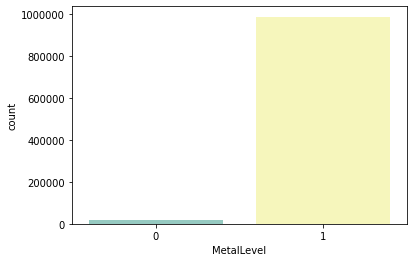

In [4]:
# class Imbalance
ax = sns.countplot(x="MetalLevel", data=healthInsurance, palette="Set3")

In [5]:
# check proportion of Dental vs. Medical
print('Dental: {}%'.format(round((healthInsurance['MetalLevel'].value_counts()[0] / healthInsurance.shape[0]), 2)*100))
print('Medical: {}%'.format(round((healthInsurance['MetalLevel'].value_counts()[1] / healthInsurance.shape[0]), 2)*100))

Dental: 2.0%
Medical: 98.0%


### Data Preprocessing

In [7]:
# reorder columns
healthInsurance = healthInsurance[['Age',
                                   'Tobacco',
                                   'BenefitName',
                                   'IsCovered',
                                   'IsExclFromInnMOOP',
                                   'IsExclFromOonMOOP',
                                   'IsEHB',
                                   'MetalLevel'
                                  ]]

In [8]:
healthInsurance.shape

(1004130, 8)

In [9]:
X = healthInsurance.iloc[:,:7]
y = healthInsurance.iloc[:,7]

In [10]:
# X_train and y_train = %80 of the original
# X_cv and y_cv = %20 of the original
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.2, random_state=10)

In [11]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel()) 
X_cv_miss, y_cv_miss = nr.fit_sample(X_cv, y_cv.ravel()) 

  
print('After Undersampling, the shape of X_train: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of y_train: {} \n'.format(y_train_miss.shape)) 

print('After Undersampling, the shape of X_cv: {}'.format(X_cv_miss.shape)) 
print('After Undersampling, the shape of y_cv: {} \n'.format(y_cv_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 


Before Undersampling, counts of label '1': 790519
Before Undersampling, counts of label '0': 12785 

After Undersampling, the shape of X_train: (25570, 7)
After Undersampling, the shape of y_train: (25570,) 

After Undersampling, the shape of X_cv: (6590, 7)
After Undersampling, the shape of y_cv: (6590,) 

After Undersampling, counts of label '1': 12785
After Undersampling, counts of label '0': 12785


In [12]:
# create list of model and accuracy dicts
perform_list = []

# list to keep track of models
models = []

# list to keep track of proba scores
proba_score = []

### MODEL SELECTION
### 1. KNN

In [13]:
from sklearn import metrics

test_scores = []
k_list = []

for i in range(1,21):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_miss,y_train_miss)
    y_pred = knn.predict(X_cv_miss)
    
    test_scores.append(metrics.accuracy_score(y_cv_miss,y_pred))
    k_list.append(i)
    
print(test_scores)

[0.644916540212443, 0.6330804248861912, 0.6467374810318665, 0.6522003034901366, 0.6553869499241275, 0.65948406676783, 0.6655538694992412, 0.6635811836115326, 0.672382397572079, 0.6701062215477998, 0.6717754172989377, 0.6705614567526555, 0.6705614567526555, 0.6757207890743551, 0.6767830045523521, 0.6783004552352049, 0.6763277693474962, 0.676176024279211, 0.6758725341426404, 0.6767830045523521]


In [14]:
max_test_score = max(test_scores)

best_k=k_list[test_scores.index(max_test_score)] 

print("Maximum K value:", best_k, "\nMaximum test score:", max_test_score)

Maximum K value: 16 
Maximum test score: 0.6783004552352049


In [15]:
knn = KNeighborsClassifier(n_neighbors=16)
knn_acc = cross_val_score(knn, X_train_miss, y_train_miss, cv=10).mean()
knn_std = cross_val_score(knn, X_train_miss, y_train_miss, cv=10).std()

# calculate accuracy of train
print('Accuracy of KNN (TRAIN): {} +/- {}'.format(round(knn_acc, 2), round(knn_std, 2)))

# fit the model
knn.fit(X_train_miss,y_train_miss)

# get predictions and probabilities
knn_pred = knn.predict(X_cv_miss)
knn_proba = knn.predict_proba(X_cv_miss)

# calculate accuracy of test
knn_acc_cv = round(accuracy_score(y_cv_miss, knn_pred), 2)
print(f'Accuracy of KNN (TEST): {knn_acc_cv}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, knn_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', knn_acc_cv),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('KNN')
# add proba socre to list
proba_score.append(knn_proba)

Accuracy of KNN (TRAIN): 0.75 +/- 0.01
Accuracy of KNN (TEST): 0.68
Precision : 0.6924006603082824
Recall    : 0.6783004552352049
F-score   : 0.6722964645979883


### 2. Logistic Regression

In [16]:
lr = LogisticRegression(random_state=1)

# calculate accuracy of train
lr_acc = cross_val_score(lr, X_train_miss, y_train_miss, cv=10).mean()
lr_std = cross_val_score(lr, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of Logistic Regression (TRAIN): {} +/- {}'.format(round(lr_acc, 2), round(lr_std, 2)))

# fit model
lr.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
lr_pred = lr.predict(X_cv_miss)
lr_proba = lr.predict_proba(X_cv_miss)

# calculate accuracy of test
lr_acc_test = round(accuracy_score(y_cv_miss, lr_pred), 2)
print(f'Accuracy of Logistic Regression (TEST): {lr_acc_test}')

print()

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', lr_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Logistic Regression')

# add proba score to list
proba_score.append(lr_proba)

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Accuracy of Logistic Regression (TRAIN): 0.69 +/- 0.01
Accuracy of Logistic Regression (TEST): 0.65

Precision : 0.6507742952806318
Recall    : 0.6450682852807283
F-score   : 0.6416781382357609


### 3. Naive Bayes

In [17]:
nb = GaussianNB()

# calculate accuracy of train
nb_acc = cross_val_score(nb, X_train_miss, y_train_miss, cv=10).mean()
nb_std = cross_val_score(nb, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of Naive Bayes Classifier (TRAIN): {} +/- {}'.format(round(nb_acc, 2), round(nb_std, 2)))

# cit model
nb.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
nb_pred = nb.predict(X_cv_miss)
nb_proba = nb.predict_proba(X_cv_miss)

# calculate accuracy of test
nb_acc_test = round(accuracy_score(y_cv_miss, nb_pred), 2)
print(f'Accuracy of Naive Bayes Classifier (TEST): {nb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, nb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(nb_acc, 2)),
    ('Test Accuracy', nb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Naive Bayes')

# add proba score to list
proba_score.append(nb_proba)

Accuracy of Naive Bayes Classifier (TRAIN): 0.59 +/- 0.01
Accuracy of Naive Bayes Classifier (TEST): 0.59

Precision : 0.7716829587370502
Recall    : 0.590743550834598
F-score   : 0.5089912449185892


### 4. Support Vector Machine (SVM)

In [18]:
svc = SVC(probability=True)

# calculate accuracy of train
svc_acc = cross_val_score(svc, X_train_miss, y_train_miss, cv=10).mean()
svc_std = cross_val_score(svc, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of SVC (TRAIN): {} +/- {}'.format(round(svc_acc, 2), round(svc_std, 2)))

# fit model
svc.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
svc_pred = svc.predict(X_cv_miss)
svc_proba = svc.predict_proba(X_cv_miss)

# calculate accuracy of test
svc_acc_test = round(accuracy_score(y_cv_miss, svc_pred), 2)
print(f'Accuracy of SVC (TEST): {svc_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, svc_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'SVC'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', svc_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('SVC')

# add proba socre to list
proba_score.append(svc_proba)

Accuracy of SVC (TRAIN): 0.66 +/- 0.01
Accuracy of SVC (TEST): 0.63
Precision : 0.6413386747364833
Recall    : 0.6338391502276176
F-score   : 0.6289166678470857


### 5. Decision Tree

In [19]:
dt = DecisionTreeClassifier()

# calculate accuracy of train
dt_acc = cross_val_score(dt, X_train_miss, y_train_miss, cv=10).mean()
dt_std = cross_val_score(dt, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of Decision Tree (TRAIN): {} +/- {}'.format(round(dt_acc, 2), round(dt_std, 2)))

# fit model
dt.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
dt_pred = dt.predict(X_cv_miss)
dt_proba = dt.predict_proba(X_cv_miss)

# calculate accuracy of test
dt_acc_test = round(accuracy_score(y_cv_miss, dt_pred), 2)
print(f'Accuracy of Decision Tree (TEST): {dt_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, dt_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Decision Tree'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', dt_acc),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Decision Tree')

# add proba socre to list
proba_score.append(dt_proba)

Accuracy of Decision Tree (TRAIN): 0.77 +/- 0.01
Accuracy of Decision Tree (TEST): 0.72

Precision : 0.7253823025624508
Recall    : 0.7153262518968133
F-score   : 0.712115057478534


In [20]:
# view feature importances
pd.DataFrame({
    'feature': X_train_miss.columns,
    'importance': dt.feature_importances_
})

,feature,importance
0,Age,0.067881
1,Tobacco,0.000000
2,BenefitName,0.476301
3,IsCovered,0.131744
4,IsExclFromInnMOOP,0.259132
5,IsExclFromOonMOOP,0.030180
6,IsEHB,0.034762


### 6. Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

# calculate accuracy of train
rf_acc = cross_val_score(rf, X_train_miss, y_train_miss, cv=10).mean()
rf_std = cross_val_score(rf, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of Random Forest (TRAIN): {} +/- {}'.format(round(rf_acc, 2), round(rf_std, 2)))

# fit model
rf.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
rf_pred = rf.predict(X_cv_miss)
rf_proba= rf.predict_proba(X_cv_miss)

# calculate accuracy of test
rf_acc_test = round(accuracy_score(y_cv_miss, rf_pred), 2)
print(f'Accuracy of Random Forest (TEST): {rf_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, rf_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', rf_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Random Forest')

# add proba socre to list
proba_score.append(rf_proba)

Accuracy of Random Forest (TRAIN): 0.77 +/- 0.01
Accuracy of Random Forest (TEST): 0.72
Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### 7. Extra Trees Classifier

In [22]:
from sklearn import model_selection

etc = ExtraTreesClassifier(n_estimators=100, max_features=7)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
etc_acc = model_selection.cross_val_score(etc, X_train_miss, y_train_miss, cv=kfold).mean()
etc_std = model_selection.cross_val_score(etc, X_train_miss, y_train_miss, cv=kfold).std()
print('Accuracy of Extra Trees Classifier (TRAIN): {} +/- {}'.format(round(etc_acc, 2), round(etc_std, 2)))

# fit model
etc.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
etc_pred = rf.predict(X_cv_miss)
etc_proba= rf.predict_proba(X_cv_miss)

# calculate accuracy of test
etc_acc_test = round(accuracy_score(y_cv_miss, etc_pred), 2)
print(f'Accuracy of Extra Trees Classifier (TEST): {etc_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, etc_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Extra Trees'),
    ('Train Accuracy', round(etc_acc, 2)),
    ('Test Accuracy', etc_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Extra Trees')

# add proba socre to list
proba_score.append(etc_proba)

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy of Extra Trees Classifier (TRAIN): 0.76 +/- 0.03
Accuracy of Extra Trees Classifier (TEST): 0.72
Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### 8. Ada Boost Classifier

In [23]:
abc = AdaBoostClassifier(n_estimators=30, random_state=7)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
abc_acc = model_selection.cross_val_score(abc, X_train_miss, y_train_miss, cv=kfold).mean()
abc_std = model_selection.cross_val_score(abc, X_train_miss, y_train_miss, cv=kfold).std()
print('Accuracy of Ada Boost Classifier (TRAIN): {} +/- {}'.format(round(abc_acc, 2), round(abc_std, 2)))

# fit model
abc.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
abc_pred = rf.predict(X_cv_miss)
abc_proba= rf.predict_proba(X_cv_miss)

# calculate accuracy of test
abc_acc_test = round(accuracy_score(y_cv_miss, abc_pred), 2)
print(f'Accuracy of Ada Boost Classifier (TEST): {abc_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, abc_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Ada Boost'),
    ('Train Accuracy', round(abc_acc, 2)),
    ('Test Accuracy', abc_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Ada Boost')

# add proba socre to list
proba_score.append(abc_proba)

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy of Ada Boost Classifier (TRAIN): 0.69 +/- 0.04
Accuracy of Ada Boost Classifier (TEST): 0.72
Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### 9. Stochastic Gradient Boost

In [24]:
sgb = GradientBoostingClassifier(n_estimators=30, random_state=7)

# calculate accuracy of train
kfold = model_selection.KFold(n_splits=10, random_state=7)
sgb_acc = model_selection.cross_val_score(sgb, X_train_miss, y_train_miss, cv=kfold).mean()
sgb_std = model_selection.cross_val_score(sgb, X_train_miss, y_train_miss, cv=kfold).std()
print('Accuracy of Stochastic Gradient Boost (TRAIN): {} +/- {}'.format(round(sgb_acc, 2), round(sgb_std, 2)))

# fit model
sgb.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
sgb_pred = rf.predict(X_cv_miss)
sgb_proba= rf.predict_proba(X_cv_miss)

# calculate accuracy of test
sgb_acc_test = round(accuracy_score(y_cv_miss, sgb_pred), 2)
print(f'Accuracy of Stochastic Gradient Boost (TEST): {sgb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, sgb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Stochastic Gradient Boost'),
    ('Train Accuracy', round(sgb_acc, 2)),
    ('Test Accuracy', sgb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Stochastic Gradient Boost')

# add proba socre to list
proba_score.append(sgb_proba)

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy of Stochastic Gradient Boost (TRAIN): 0.66 +/- 0.05
Accuracy of Stochastic Gradient Boost (TEST): 0.72
Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### 10. XGB Classifier

In [25]:
import xgboost as xgb
xgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

# calculate accuracy of train
xgb_acc = cross_val_score(sgb, X_train_miss, y_train_miss, cv=10).mean()
xgb_std = cross_val_score(sgb, X_train_miss, y_train_miss, cv=10).std()
print('Accuracy of XGBoost (TRAIN): {} +/- {}'.format(round(xgb_acc, 2), round(xgb_std, 2)))

# fit model
xgb.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
xgb_pred = rf.predict(X_cv_miss)
xgb_proba= rf.predict_proba(X_cv_miss)

# calculate accuracy of test
xgb_acc_test = round(accuracy_score(y_cv_miss, xgb_pred), 2)
print(f'Accuracy of XGBoost (TEST): {sgb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, xgb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'XGBoost'),
    ('Train Accuracy', round(xgb_acc, 2)),
    ('Test Accuracy', xgb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('XGBoost')

# add proba socre to list
proba_score.append(xgb_proba)

Accuracy of XGBoost (TRAIN): 0.75 +/- 0.01
Accuracy of XGBoost (TEST): 0.72
Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### Model Performance

In [26]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,KNN,0.75,0.680000,0.69,0.68,0.67
1,Logistic Regression,0.69,0.650000,0.65,0.65,0.64
2,Naive Bayes,0.59,0.590000,0.77,0.59,0.51
3,SVC,0.66,0.630000,0.64,0.63,0.63
4,Decision Tree,0.77,0.774384,0.73,0.72,0.71
5,Random Forest,0.77,0.720000,0.73,0.72,0.71
6,Extra Trees,0.76,0.720000,0.73,0.72,0.71
7,Ada Boost,0.69,0.720000,0.73,0.72,0.71
8,Stochastic Gradient Boost,0.66,0.720000,0.73,0.72,0.71
9,XGBoost,0.75,0.720000,0.73,0.72,0.71


In [27]:
models

['KNN',
 'Logistic Regression',
 'Naive Bayes',
 'SVC',
 'Decision Tree',
 'Random Forest',
 'Extra Trees',
 'Ada Boost',
 'Stochastic Gradient Boost',
 'XGBoost']

### ROC CURVE

In [28]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # KNN
    fpr, tpr, thresholds = roc_curve(y_cv_miss, knn_proba[:,1], pos_label=1)
    auc_knn = roc_auc_score(y_cv_miss, knn_proba[:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN, auc=%.3f' % auc_knn)
    
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_cv_miss, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_cv_miss, lr_proba[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR, auc=%.3f' % auc_lr)
         
    # SVC
    fpr, tpr, thresholds = roc_curve(y_cv_miss, svc_proba[:,1], pos_label=1)
    auc_svc = roc_auc_score(y_cv_miss, svc_proba[:,1])
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='SVC, auc=%.3f' % auc_svc)
    
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_cv_miss, nb_proba[:,1], pos_label=1)
    auc_nbc = roc_auc_score(y_cv_miss, nb_proba[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='Naive Bayes, auc=%.3f' % auc_nbc)
    
    # Decision Tree
    fpr, tpr, thresholds = roc_curve(y_cv_miss, dt_proba[:,1], pos_label=1)
    auc_dt = roc_auc_score(y_cv_miss, dt_proba[:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='Decision Tree, auc=%.3f' % auc_dt)
   
    # Random Forest 
    fpr, tpr, thresholds = roc_curve(y_cv_miss, rf_proba[:,1], pos_label=1)
    auc_rf = roc_auc_score(y_cv_miss, rf_proba[:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='Random Forest, auc=%.3f' % auc_rf)
     
    # Extra Trees
    fpr, tpr, thresholds = roc_curve(y_cv_miss, etc_proba[:,1], pos_label=1)
    auc_etc = roc_auc_score(y_cv_miss, etc_proba[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Extra Trees, auc=%.3f' % auc_etc)
    
    # Ada Boost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_miss, abc_proba[:,1], pos_label=1)
    auc_abc = roc_auc_score(y_cv_miss, abc_proba[:,1])
    plt.plot(fpr, tpr, color='#00cc99',
             lw=lw, label='Ada Boost, auc=%.3f' % auc_abc)
    
    # Stochastic Gradient Boost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_miss, sgb_proba[:,1], pos_label=1)
    auc_sgb = roc_auc_score(y_cv_miss, sgb_proba[:,1])
    plt.plot(fpr, tpr, color='#08e8de',
             lw=lw, label='Stochastic Gradient Boost, auc=%.3f' % auc_sgb)
    
    # XGBoost Classifier
    fpr, tpr, thresholds = roc_curve(y_cv_miss, xgb_proba[:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_cv_miss, xgb_proba[:,1])
    plt.plot(fpr, tpr, color='#f4bbff',
             lw=lw, label='XGBoost, auc=%.3f' % auc_xgb)    
    
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

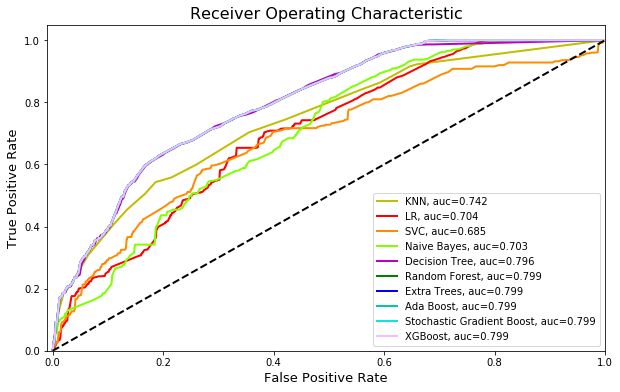

In [29]:
plot_roc_curves()

In [30]:
# create list of model and accuracy dicts
gridPerformList = []

# list to keep track of models
gridModelsList= []

# list to keep track of proba scores
gridProbaList = []

### Random Forest GridSearchCV

In [31]:
# search the best parameter
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5], "min_samples_split" : [2, 4], "n_estimators": [100, 400]}
rf_cv = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf_cv, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train_miss, y_train_miss)
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [32]:
# apply best parameter to model
rf_grid = RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                min_samples_split=2,
                                min_samples_leaf=1,)

# calculate the accuracy of train
rf_grid_acc = cross_val_score(rf_grid, X_train_miss, y_train_miss).mean()
rf_grid_std = cross_val_score(rf_grid, X_train_miss, y_train_miss).std()
print('Accuracy of Random Forest GS (TRAIN): {} +/- {}'.format(round(rf_grid_acc, 2), round(rf_grid_std, 2)))

# fit model
rf_grid.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
rf_grid_pred = rf_grid.predict(X_cv_miss)
rf_grid_proba = rf_grid.predict_proba(X_cv_miss)

# calculate accuracy of test
rf_grid_acc_test = round(accuracy_score(y_cv_miss, rf_grid_pred), 2)
print(f'Accuracy of Random Forest GS (TEST): {rf_grid_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, rf_grid_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
gridPerformList.append(dict([
    ('Model', 'Random Forest GS'),
    ('Train Accuracy', round(rf_grid_acc, 2)),
    ('Test Accuracy', rf_grid_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
gridModelsList.append('Random Forest GS')

# add proba socre to list
gridProbaList.append(rf_grid_proba)



Accuracy of Random Forest GS (TRAIN): 0.77 +/- 0.0
Accuracy of Random Forest GS (TEST): 0.72

Precision : 0.7264517374517374
Recall    : 0.7160849772382397
F-score   : 0.7127980140259706


### Random Forest RandomizedSearchCV

In [33]:
# search the best parameter
n_estimators_range = [x for x in range(1,31)]
criterion_range = ['gini', 'entropy']
max_features_range = [None, 'auto', 'log2', 1, 2, 3]
max_depth_range = [None, 1, 2, 3]
min_samples_split_range = [10, 20, 50]
min_samples_leaf_range = [10, 20, 50]
bootstrap_range = [True, False]

param_random = dict(n_estimators=n_estimators_range,
                     criterion=criterion_range,
                     max_features=max_features_range,
                     max_depth=max_depth_range,
                     min_samples_split=min_samples_split_range,
                     min_samples_leaf=min_samples_leaf_range,
                     bootstrap=bootstrap_range
)

# choose number of searches
n_iter_search = 40

rf_random = RandomizedSearchCV(rf, param_distributions=param_random, n_iter=n_iter_search)

# fit the model
rf_random.fit(X_train_miss, y_train_miss)

rf_random.best_params_

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/li

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/li

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbali/opt/anaconda3/li

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn

/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/yagmurbali/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/Users/yagmurbal

{'n_estimators': 19,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

In [34]:
# apply best parameter to model 
rf_random = RandomForestClassifier(n_estimators=19,
                                criterion='gini',
                                max_features=4,
                                max_depth=None,
                                min_samples_split=50,
                                min_samples_leaf=10,
                                bootstrap=True,
                                random_state=1)

# calculate the accuracy of train
rf_random_acc = cross_val_score(rf_random, X_train_miss, y_train_miss).mean()
rf_randomt_std = cross_val_score(rf_random, X_train_miss, y_train_miss).std()
print('Accuracy of Random Forest RS (TRAIN): {} +/- {}'.format(round(rf_random_acc, 2), round(rf_randomt_std, 2)))

# fit model
rf_random.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
rf_random_pred = rf_random.predict(X_cv_miss)
rf_random_proba = rf_random.predict_proba(X_cv_miss)

# calculate accuracy of test
rf_random_acc_test = round(accuracy_score(y_cv_miss, rf_random_pred), 2)
print(f'Accuracy of Random Forest RS (TEST): {rf_random_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, rf_random_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
gridPerformList.append(dict([
    ('Model', 'Random Forest RS'),
    ('Train Accuracy', round(rf_random_acc, 2)),
    ('Test Accuracy', rf_random_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
gridModelsList.append('Random Forest RS')

# add proba socre to list
gridProbaList.append(rf_random_proba)

Accuracy of Random Forest RS (TRAIN): 0.77 +/- 0.01
Accuracy of Random Forest RS (TEST): 0.71

Precision : 0.7149528477110971
Recall    : 0.7084977238239758
F-score   : 0.7062926854608036


### Decision Tree GridSearchCV

In [35]:
# find the best parameter
criterion_range = ['gini', 'entropy']
splitter_range = ['best', 'random']
max_depth_range = [None, 1, 2, 3]
min_samples_split_range = [10, 20]
min_samples_leaf_range = [10, 20]

param_grid2 = dict(criterion=criterion_range,
                    splitter=splitter_range,
                    max_depth=max_depth_range,
                    min_samples_split=min_samples_split_range,
                    min_samples_leaf=min_samples_leaf_range
)

dt_cv = GridSearchCV(dt, param_grid2)

# fit the model
dt_cv.fit(X_train_miss, y_train_miss)

dt_cv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'splitter': 'random'}

In [37]:
# apply best parameter to model
dt_grid = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=None,
                                min_samples_split=10, min_samples_leaf=10, random_state=1)

# calculate accuracy
dt_grid_acc = cross_val_score(dt_grid, X_train_miss, y_train_miss).mean()
dt_grid_std = cross_val_score(dt_grid, X_train_miss, y_train_miss).std()
print('Accuracy of Decision Tree GridSearchCV (TEST): {} +/- {}'.format(round(dt_grid_acc, 2), round(dt_grid_std, 2)))

# fit model
dt_grid.fit(X_train_miss, y_train_miss)

# get predictions and probabilities
dt_grid_pred = dt_grid.predict(X_cv_miss)
dt_grid_proba = dt_grid.predict_proba(X_cv_miss)

# calculate accuracy of test
dt_grid_acc_test = round(accuracy_score(y_cv_miss, dt_grid_pred), 2)
print(f'Accuracy of Decision Tree GridSearchCV (TEST): {dt_grid_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_cv_miss, dt_grid_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
gridPerformList.append(dict([
    ('Model', 'Decision Tree GS'),
    ('Train Accuracy', round(dt_grid_acc, 2)),
    ('Test Accuracy', dt_grid_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
gridModelsList.append('Decision Tree GS')

# add proba socre to list
gridProbaList.append(dt_grid_proba)

Accuracy of Decision Tree GridSearchCV (TEST): 0.77 +/- 0.0
Accuracy of Decision Tree GridSearchCV (TEST): 0.71

Precision : 0.7167678163727557
Recall    : 0.7118361153262519
F-score   : 0.7101877300876904


In [38]:
# view feature importances
pd.DataFrame({
    'feature': X_train_miss.columns,
    'importance': dt_grid.feature_importances_
})

,feature,importance
0,Age,0.032001
1,Tobacco,0.000000
2,BenefitName,0.462602
3,IsCovered,0.136591
4,IsExclFromInnMOOP,0.297341
5,IsExclFromOonMOOP,0.045605
6,IsEHB,0.025860


### Model Performance After Optimization

In [39]:
model_perf_grid = pd.DataFrame(data=gridPerformList)
model_perf_grid = model_perf_grid[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_perf_grid

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,Random Forest GS,0.77,0.72,0.73,0.72,0.71
1,Random Forest RS,0.77,0.71,0.71,0.71,0.71
2,Decision Tree GS,0.77,0.71,0.72,0.71,0.71


In [40]:
# add first models table to the grid models table
all_models = pd.concat([model_performance, model_perf_grid], ignore_index=True)
all_models

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,KNN,0.75,0.680000,0.69,0.68,0.67
1,Logistic Regression,0.69,0.650000,0.65,0.65,0.64
2,Naive Bayes,0.59,0.590000,0.77,0.59,0.51
3,SVC,0.66,0.630000,0.64,0.63,0.63
4,Decision Tree,0.77,0.774384,0.73,0.72,0.71
5,Random Forest,0.77,0.720000,0.73,0.72,0.71
6,Extra Trees,0.76,0.720000,0.73,0.72,0.71
7,Ada Boost,0.69,0.720000,0.73,0.72,0.71
8,Stochastic Gradient Boost,0.66,0.720000,0.73,0.72,0.71
9,XGBoost,0.75,0.720000,0.73,0.72,0.71


**As we can see above, best 3 models are:**

**1- Decision Tree**

**2- Random Forest**

**3- Extra Trees Classifier**

### Confusion Matrix for Best Models

In [51]:
print("Extra Tree confusion matrix: \n\n", confusion_matrix(y_cv_miss, etc.predict(X_cv_miss)))

Extra Tree confusion matrix: 

 [[2711  584]
 [1288 2007]]


In [45]:
print("Decision Tree confusion matrix: \n\n", confusion_matrix(y_cv_miss, dt.predict(X_cv_miss)))

Decision Tree confusion matrix: 

 [[2705  590]
 [1286 2009]]


In [46]:
print("Random Forest confusion matrix: \n\n", confusion_matrix(y_cv_miss, rf.predict(X_cv_miss)))

Random Forest confusion matrix: 

 [[2712  583]
 [1288 2007]]


In [1]:
# Print confusion matrix for kNN
#rf_confusion = confusion_matrix(y_cv_miss, rf.predict(X_cv_miss))
#plt.figure(dpi=150)
#sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
#           xticklabels=healthInsurance['MetalLevel'],
#           yticklabels=healthInsurance['MetalLevel'])

#plt.xlabel('Predicted Metal Level')
#plt.ylabel('Actual Metal Level')
#plt.title('Random Forest confusion matrix');